<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Lesson_6_Pets_More_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 6: Regularization; Convolutions; Data ethics

https://course.fast.ai/videos/?lesson=6

https://github.com/hiromis/notes/blob/master/Lesson6.md


Today we discuss some powerful techniques for improving training and avoiding over-fitting:

* Dropout: remove activations at random during training in order to regularize the model
* Data augmentation: modify model inputs during training in order to effectively increase data size
* Batch normalization: adjust the parameterization of a model in order to make the loss surface smoother.

Next up, we'll learn all about convolutions, which can be thought of as a variant of matrix multiplication with tied weights, and are the operation at the heart of modern computer vision models (and, increasingly, other types of models too).

We'll use this knowledge to create a class activated map, which is a heat-map that shows which parts of an image were most important in making a prediction.

Finally, we'll cover a topic that many students have told us is the most interesting and surprising part of the course: data ethics. We'll learn about some of the ways in which models can go wrong, with a particular focus on feedback loops, why they cause problems, and how to avoid them. We'll also look at ways in which bias in data can lead to biased algorithms, and discuss questions that data scientists can and should be asking to help ensure that their work doesn't lead to unexpected negative outcomes.

[Notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb)

# Notes

RNN tends to performs well perhaps on acadmic data without complex entity relationships.

Recognizing cyclic or seasonal data requires "date" to be in category formal. For equity trading, however, you may need to do more than just that. 

Sales is the depnding variable with the rest being features required to predict sales.

Procs: 
* Runs once on the train set and all resulting meta-date is shared with test & validation 

data.export 
* saves the entire databunch 

Need to seperate categorial and continous data.

categorial
* May exposes implicit values through embedding matrix
* If in doubt, try it out

LabelClass: FloatList 
* Must be Float for regression 
* set to FloatList to tunr the learner into a regressor  


log = true 
* logarithm of y 
* when RMSPE error function 
* when you take the log of RSME, it becomes the RMSPE 
* long tail distributions require percentage change differences, this RMSPE needs to be measured 
* Set log range of y a bit wider 

Model architecture 
* Most basic NN FCN
* interemediate weighmtraix (1000X500) - 500k a lot for just a hundred few features 
* Use regularization, weight decay, and dropout  to avoid overfitting
* Weight decay is already applied automocatlly by the fast.ai lib

Dropout: 
* kind of regularization 
* Randoomly drops activations  from the net
* Removes connection between nodes
* For each batch, we through away ~5% of activations and inputs 
* On the next batch, the previous drops are restored, and ot hers are dropped randoomly.
* No one activation can memorize the input
* Therefore, instead of memorizing one specific input (image), the net must learn to recognize features
* In practice, it works very well.
* Requires a bit of tweaking of the ps (p value of droput values) to figure out which one works best

Embedding dropout 
* Special dropout for embedding 
* Embedding is  a matrix multiply with aone-hot encoded
* Thus, randoom drops can be dine 
* Experiments showed that embeeding dropout increased acc. with low erreror variance



Data Augmentation:
* Look at the range of the actual data and chose augmentation close to the real data
* Warping seems to work well 
* Biggest opportunity is to apply data augmentation in other domains 
* Can reduce data requirements by 5 to 10 X 

## Install 

In [0]:
!pip install imgaug==0.2.6

!pip install folium==0.2.1

!pip install --upgrade pandas

!pip install --upgrade numpy

!pip install isoweek

#!pip install --upgrade fastai

!curl -s https://course.fast.ai/setup/colab | bash

## Constants & global flags

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

bs = 64
# bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Import Fast.ai & PyTorch


In [72]:
import fastai
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt

print("FastAI Version: " + str(fastai.__version__))

FastAI Version: 1.0.51


In [6]:
import torch

print("PyTorch Version: " + str(torch.__version__))

PyTorch Version: 1.0.1.post2


## CUDA GPU *acceleration*

In [0]:
def check_cuda():
  torch.cuda.current_device()
  print("Cuda available: " + str(torch.cuda.is_available()))
  print("Cuda enabled:" + str(torch.backends.cudnn.enabled))
  #https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
  # setting device on GPU if available, else CPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)
  print()
  #Additional Info when using cuda
  if device.type == 'cuda':
    check_cuda_mem()


In [0]:
def check_cuda_mem():
      print("GPU used: " + torch.cuda.get_device_name(0))
      print('Memory Usage:')
      print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
      print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
  

In [0]:
def clear_cuda_cache(learn):
  # Clear Cuda cache, if running OOM
    learn.destroy()
    torch.cuda.empty_cache()
    check_cuda_mem()

In [29]:
check_cuda()

Cuda available: True
Cuda enabled:True
Using device: cuda

GPU used: Tesla K80
Memory Usage:
Allocated: 10.6 GB
Cached:    10.8 GB


# Data Augmentation

In [0]:
path = untar_data(URLs.PETS)/'images'


In [0]:
tfms = get_transforms(max_rotate=20, 
                      max_zoom=1.3, 
                      max_lighting=0.4, 
                      max_warp=0.4,
                      p_affine=1., 
                      p_lighting=1.)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)


In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224, bs, 'zeros')


In [0]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data = get_data(224,bs)


In [0]:
plot_multi(_plot, 3, 3, figsize=(8,8))

# Train Model

In [32]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)
# Try different pre-trained model 
# ResNet-152	has the lowest Top-1% error from all torch vision models 
# https://pytorch.org/docs/stable/torchvision/models.html
#learn = cnn_learner(data, models.resnet50, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:02, 34638998.74it/s]


In [36]:
check_cuda_mem()

GPU used: Tesla K80
Memory Usage:
Allocated: 0.1 GB
Cached:    0.7 GB


In [31]:
print(""""Clear CUDA Memory""")
clear_cuda_cache(learn)

this Learner object self-destroyed - it still exists, but no longer usable
GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Model comparision 

Error-rate after 3 epochs: 
* resnet34: 0.066982
* resnet50: 0.056834
* resnet152: 0.055480

In [35]:
# Pre-train one epoch with high initial rate 
learn.fit_one_cycle(1, 5e-3, pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.061035,0.755568,0.115020,03:31


In [37]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)


epoch,train_loss,valid_loss,error_rate,time
0,1.340412,0.602779,0.074425,03:28
1,0.989494,0.268960,0.075101,03:24
2,0.721541,0.217879,0.060217,03:25


In [38]:
learn.unfreeze() # update entire net 
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.580589,0.221174,0.048038,03:37
1,0.559205,0.218753,0.045332,03:39


In [39]:
check_cuda_mem()

GPU used: Tesla K80
Memory Usage:
Allocated: 0.3 GB
Cached:    6.4 GB


In [0]:
#incresse inage size 
data = get_data(352,bs)
learn.data = data

In [41]:
# fit net to  higher res images
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.496456,0.214484,0.041272,03:43
1,0.484157,0.216605,0.043978,03:51


In [0]:
learn.save('352')


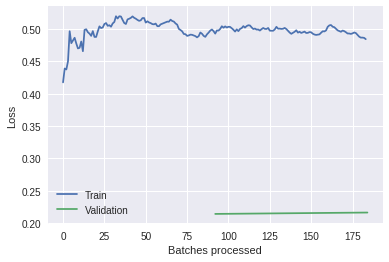

In [43]:
learn.recorder.plot_losses()


In [0]:
# show summary 
print(learn.summary())


In [0]:
#incresse inage size 
data = get_data(480,bs)
learn.data = data# fit net to  higher res images

learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [0]:
learn.recorder.plot_losses()


# Convolution kernel¶


In [0]:
data = get_data(352,16)


In [82]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

SyntaxError: ignored

Category basset_hound

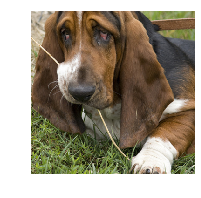

In [89]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [48]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [49]:
k.shape


torch.Size([1, 3, 3, 3])

In [50]:
t = data.valid_ds[0][0].data; t.shape
t[None].shape


torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)


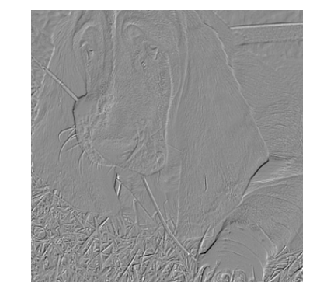

In [52]:
# Apply kernal to image for edge detection 
show_image(edge[0], figsize=(5,5));


In [53]:
data.c


37

In [0]:
learn.model


In [0]:
print(learn.summary())


# Heatmap

In [0]:
m = learn.model.eval()


In [0]:
def get_image(idx:int):
  return data.valid_ds[idx]

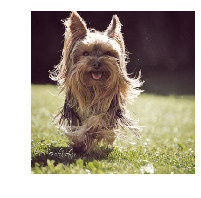

In [101]:
x,y = get_image(2)
x.show()

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda() 

In [0]:
from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()


hook_a,hook_g = hooked_backward()


In [62]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [66]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

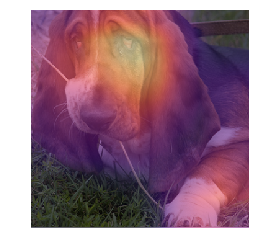

In [74]:
show_heatmap(avg_acts)


# Grad-CAM

In [75]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)


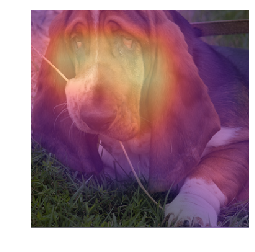

In [77]:
show_heatmap(mult)


Try another image

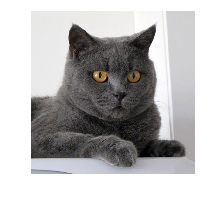

In [117]:
#fn = path/'../othe/bulldog_maine.jpg' #Replace with your own image
#x= open_image(fn); x

x,y = get_image(12)


x.show()

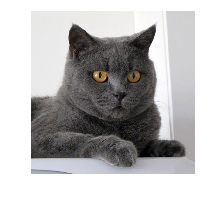

In [118]:
x.show()

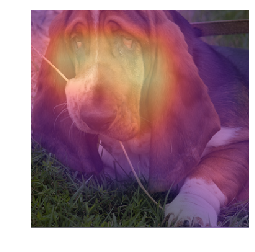

In [121]:
render_heatmap(x)

In [0]:
def render_heatmap(x):
  xb,_ = data.one_item(x)
  xb_im = Image(data.denorm(xb)[0])
  xb = xb.cuda()
  
  hook_a,hook_g = hooked_backward()
  
  acts = hook_a.stored[0].cpu()
  grad = hook_g.stored[0][0].cpu()

  grad_chan = grad.mean(1).mean(1)
  mult = (acts*grad_chan[...,None,None]).mean(0)
  show_heatmap(mult)

In [108]:
data.classes[0]


'Abyssinian'

In [0]:
hook_a,hook_g = hooked_backward(0)


In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

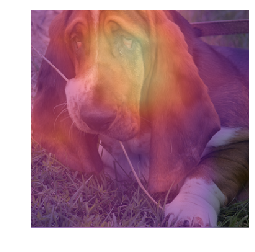

In [111]:
show_heatmap(mult)
